# Twilight Cosmology v3 — WFD vs WFD+Twilight (Combined)

Purpose:
- Read the WFD EP-LSST (LOWZ+HIGHZ) simulation and select a Year-1 window.
- Read the Twilight-only simulation and select its Year-1 window.
- Plot Year-1 N(z) in the style of `show_fig_y1_nz`.
- Build binned catalogs for WFD and Twilight; combine bins (N, sigma_mu) and run Fisher forecasts.
- Compare cosmology (WFD vs WFD+Twilight) and print per-bin differences.

Notes:
- WFD and Twilight Year-1 windows are determined independently via densest 365.25-day spans.
- Bin combination uses inverse-variance logic: sigma_bin = sqrt((N1+N2) / (N1/s1^2 + N2/s2^2)).
- All helper functions are under `Motivation/` and already used in v0/v1/v2.

In [1]:
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd
import sys, pathlib

# Ensure project root is importable
root = pathlib.Path.cwd().parent
if str(root) not in sys.path:
    sys.path.insert(0, str(root))

from Motivation import (
    DZ_DEFAULT, Z_MAX_DEFAULT, Z_TW_MIN_DEFAULT, Z_TW_MAX_DEFAULT,
    read_head_fits, read_fitres_any, standardize_fitres, read_phot_fits,
    ross_qc_with_report, densest_year_window,
    load_snana_fitres_ascii, load_snana_head_fits,
    nz_hist, write_binned_catalogs_v2, load_binned_catalogs,
    sigma_mu_per_sn,
    run_binned_forecast, summarize_y1_counts_in_range,
    show_fig_y1_nz, plot_lcdm_1d, plot_corner
)


In [2]:
# Global configuration
DERIVED = Path("/Users/tz/Documents/GitHub/Lsst-Twilight-SNe/Motivation/derived")
DERIVED.mkdir(parents=True, exist_ok=True)

DZ = DZ_DEFAULT
Z_MAX = Z_MAX_DEFAULT
Z_TW_MIN, Z_TW_MAX = Z_TW_MIN_DEFAULT, Z_TW_MAX_DEFAULT


## Read WFD (EP-LSST) and select Year-1

In [3]:
# EP-LSST input paths (unchanged from v2)
BASE = Path("/Users/tz/Documents/GitHub/Lsst-Twilight-SNe/Motivation/data_snana_EP_LSST")
HEAD_HIGHZ = BASE / "1_SIM/PIP_EP-LSST_LSST_P21_HIGHZ/PIP_EP-LSST_LSST_P21_HIGHZ_SNIaMODEL00-0001_HEAD.FITS.gz"
HEAD_LOWZ  = BASE / "1_SIM/PIP_EP-LSST_LSST_P21_LOWZ/PIP_EP-LSST_LSST_P21_LOWZ_SNIaMODEL00-0001_HEAD.FITS.gz"
PHOT_HIGHZ = BASE / "1_SIM/PIP_EP-LSST_LSST_P21_HIGHZ/PIP_EP-LSST_LSST_P21_HIGHZ_SNIaMODEL00-0001_PHOT.FITS.gz"
PHOT_LOWZ  = BASE / "1_SIM/PIP_EP-LSST_LSST_P21_LOWZ/PIP_EP-LSST_LSST_P21_LOWZ_SNIaMODEL00-0001_PHOT.FITS.gz"
FITRES_HIGHZ_ASCII = BASE / "2_LCFIT/PIP_EP-LSST_LSST_P21_HIGHZ/FITOPT000.FITRES.gz"
FITRES_LOWZ_ASCII  = BASE / "2_LCFIT/PIP_EP-LSST_LSST_P21_LOWZ/FITOPT000.FITRES.gz"
FITRES_LOWZ_ROOT   = BASE / "2_LCFIT/PIP_EP-LSST_LSST_P21_LOWZ/FITOPT000.ROOT.gz"

# Read HEAD/PHOT/FITRES and standardize
head_hi = read_head_fits(HEAD_HIGHZ)
head_lo = read_head_fits(HEAD_LOWZ)
head_all = pd.concat([head_lo, head_hi], ignore_index=True)

fit_hi = standardize_fitres(read_fitres_any(FITRES_HIGHZ_ASCII))
fit_lo = standardize_fitres(read_fitres_any(FITRES_LOWZ_ASCII if FITRES_LOWZ_ASCII.exists() else FITRES_LOWZ_ROOT))
fit_all = pd.concat([fit_lo, fit_hi], ignore_index=True)

phot_hi = read_phot_fits(PHOT_HIGHZ)
phot_lo = read_phot_fits(PHOT_LOWZ)

# Type Ia and z-range filters
if "SNTYPE" in head_all.columns:
    head_all = head_all.loc[head_all["SNTYPE"] == 1].copy()
head_all["z"] = pd.to_numeric(head_all.get("z", np.nan), errors="coerce")
head_all = head_all.loc[(head_all["z"] > 0) & (head_all["z"] <= Z_MAX)].copy()

fit_all["z"] = pd.to_numeric(fit_all.get("z", np.nan), errors="coerce")
fit_all = fit_all.loc[(fit_all["z"] > 0) & (fit_all["z"] <= Z_MAX)].copy()

# Year-1 selection window by densest PKMJD span
t0_wfd, t1_wfd = densest_year_window(fit_all)
head_y1 = head_all.loc[(head_all["PKMJD"] >= t0_wfd) & (head_all["PKMJD"] < t1_wfd)].copy()

# Apply Ross-style QC using both runs' HEAD/PHOT
fit_qc = ross_qc_with_report(
    fit_all,
    head_hi=head_hi, phot_hi=phot_hi,
    head_lo=head_lo, phot_lo=phot_lo,
    phot_hi_path=PHOT_HIGHZ, phot_lo_path=PHOT_LOWZ,
    verbose=True,
)
fit_qc_y1 = fit_qc.loc[(fit_qc["PKMJD"] >= t0_wfd) & (fit_qc["PKMJD"] < t1_wfd)].copy()
print(f"WFD Year-1 window: [{t0_wfd:.2f}, {t1_wfd:.2f})")
print(f"WFD counts — HEAD Y1: {len(head_y1)}, FITRES QC Y1: {len(fit_qc_y1)}")


[ROSS QC] FITPROB>0.05       keep=188012/191028 (98.4%)
[ROSS QC] |x1|<=3.00         keep=186900/191028 (97.8%)
[ROSS QC] |c|<=0.30          keep=184970/191028 (96.8%)
[ROSS QC] PKMJDERR<=1.0d     keep=136457/191028 (71.4%)
[ROSS QC] x1ERR<=1.00        keep=145407/191028 (76.1%)
[ROSS QC] cERR<=0.05         keep= 72781/191028 (38.1%)
[ROSS QC] >=3 obs ±10d       keep=184157/191028 (96.4%)
[ROSS QC] no saturation      keep=191024/191028 (100.0%)
[ROSS QC] TOTAL          keep= 63365/191028 (33.2%)
WFD Year-1 window: [61199.44, 61564.69)
WFD counts — HEAD Y1: 27335, FITRES QC Y1: 7883


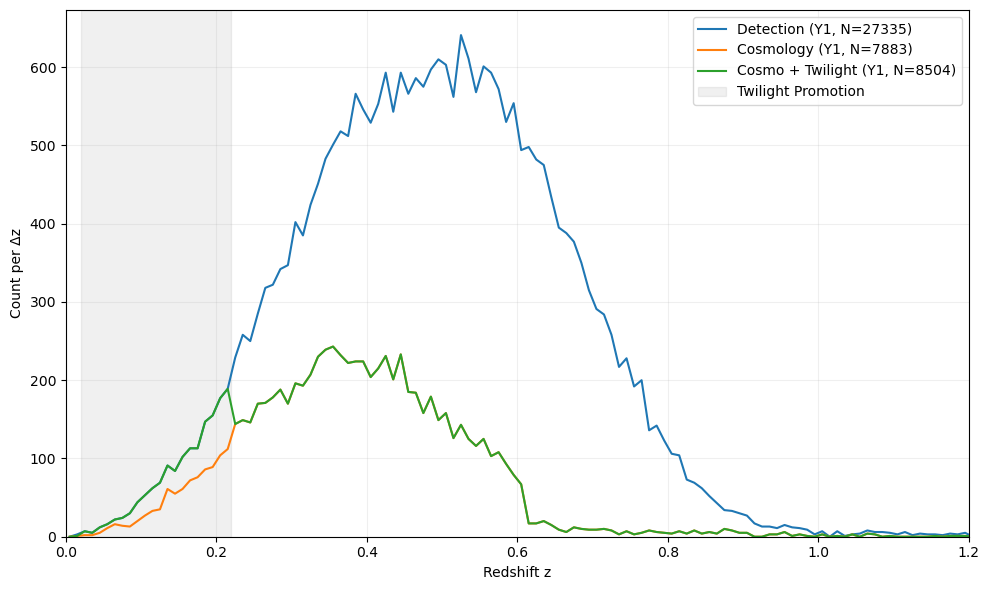

WFD redshift summaries:
  z∈[0.02,0.06): {'N_det': 40, 'N_cos': 20, 'N_cos_tw': 40}
  z∈[0.02,0.10): {'N_det': 160, 'N_cos': 83, 'N_cos_tw': 160}
  z∈[0.02,0.14): {'N_det': 435, 'N_cos': 239, 'N_cos_tw': 435}
  z∈[0.06,0.10): {'N_det': 120, 'N_cos': 63, 'N_cos_tw': 120}
  z∈[0.10,0.14): {'N_det': 275, 'N_cos': 156, 'N_cos_tw': 275}


In [4]:
# Plot Year-1 N(z) for WFD
z_edges = np.arange(0.0, Z_MAX + DZ + 1e-12, DZ)
z_mid   = 0.5 * (z_edges[:-1] + z_edges[1:])
N_det = nz_hist(head_y1["z"].to_numpy(float), z_edges)
N_cos = nz_hist(fit_qc_y1["z"].to_numpy(float), z_edges)

show_fig_y1_nz(z_mid, N_det, N_cos, DZ=DZ, Z_TW_MIN=Z_TW_MIN, Z_TW_MAX=Z_TW_MAX, Z_MAX=Z_MAX)
print("WFD redshift summaries:")
for rng in [(0.02,0.06),(0.02,0.10),(0.02,0.14),(0.06,0.10),(0.10,0.14)]:
    print(f"  z∈[{rng[0]:.2f},{rng[1]:.2f}):", summarize_y1_counts_in_range(z_mid, N_det, N_cos, z_min=rng[0], z_max=rng[1], dz=DZ))


In [5]:
# Build WFD binned catalogs and keep for forecasts
wfd_base_csv, wfd_tw_csv = write_binned_catalogs_v2(
    derived_dir=DERIVED,
    head_y1=head_y1,
    fit_qc_y1=fit_qc_y1,
    base_label="ep_lsst",
    dz=DZ,
    z_max=Z_MAX,
)
bins = load_binned_catalogs(DERIVED, z_max=Z_MAX)
df_wfd_bin     = bins["WFD"]
df_wfd_tw_guess = bins.get("WFD+Twilight (Guess)")  # if present
print(f"Loaded WFD binned: {len(df_wfd_bin)} bins")


Loaded WFD binned: 120 bins


/Users/tz/Documents/GitHub/Lsst-Twilight-SNe/Motivation/tw_binning.py:545: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = s.fillna(method="ffill").fillna(method="bfill")
/Users/tz/Documents/GitHub/Lsst-Twilight-SNe/Motivation/tw_binning.py:545: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = s.fillna(method="ffill").fillna(method="bfill")
/Users/tz/Documents/GitHub/Lsst-Twilight-SNe/Motivation/tw_binning.py:545: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = s.fillna(method="ffill").fillna(method="bfill")
/Users/tz/Documents/GitHub/Lsst-Twilight-SNe/Motivation/tw_binning.py:545: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = 

## Read Twilight-only and select Year-1

In [6]:
# Twilight-only inputs (apply ROSS QC and select Twilight Year-1)
TW_BASE = Path("/Users/tz/Documents/GitHub/Lsst-Twilight-SNe/Motivation/data_twilightv4")
TW_HEAD = TW_BASE / "PIP_TZ_LSST_TWILIGHT_MIDW43b34_SNIaMODEL00-0001_HEAD.FITS"
TW_PHOT = TW_BASE / "PIP_TZ_LSST_TWILIGHT_MIDW43b34_SNIaMODEL00-0001_PHOT.FITS"
TW_FITRES_ASCII = TW_BASE / "FITOPT000.FITRES"

# Use full readers to get IDs/PKMJD for QC + Year-1 selection
tw_head_full = read_head_fits(TW_HEAD)
tw_phot_df = read_phot_fits(TW_PHOT)
tw_fitres_raw = load_snana_fitres_ascii(TW_FITRES_ASCII, prefer_z=("zHD", "zCMB", "z"))
tw_fitres = standardize_fitres(tw_fitres_raw)
# Fallback: ensure PKMJD exists in Twilight FITRES by joining from HEAD if needed
if ('PKMJD' not in tw_fitres.columns) or (pd.to_numeric(tw_fitres.get('PKMJD'), errors='coerce').notna().sum() == 0):
    if 'ID_int' in tw_fitres.columns and 'ID_int' in tw_head_full.columns:
        tmp = tw_fitres.merge(tw_head_full[['ID_int','PKMJD']], on='ID_int', how='left', suffixes=('', '_HEAD'))
        if 'PKMJD_HEAD' in tmp.columns and (('PKMJD' not in tmp.columns) or tmp['PKMJD'].isna().all()):
            tmp['PKMJD'] = tmp['PKMJD_HEAD']
        tw_fitres = tmp.drop(columns=[c for c in ['PKMJD_HEAD'] if c in tmp.columns])

# Apply Ross-style QC on Twilight FITRES using Twilight HEAD/PHOT
tw_fit_qc_all = ross_qc_with_report(
    tw_fitres,
    head_hi=tw_head_full, phot_hi=tw_phot_df,
    head_lo=tw_head_full, phot_lo=tw_phot_df,
    phot_hi_path=TW_PHOT, phot_lo_path=TW_PHOT,
    verbose=True,
)

# Determine Twilight densest Year-1 window and select it for HEAD and QC'ed FITRES
t0_tw, t1_tw = densest_year_window(tw_head_full)
tw_head_y1 = tw_head_full[(tw_head_full['PKMJD'] >= t0_tw) & (tw_head_full['PKMJD'] < t1_tw)].copy()
tw_fit_qc_y1 = tw_fit_qc_all[(tw_fit_qc_all['PKMJD'] >= t0_tw) & (tw_fit_qc_all['PKMJD'] < t1_tw)].copy()

# Build WFD base + WFD+Twilight combined bins; use Twilight QC+Y1 for promoted inputs
tw_base_csv, tw_tw_csv = write_binned_catalogs_v2(
    derived_dir=DERIVED,
    head_y1=tw_head_y1,
    fit_qc_y1=fit_qc_y1,
    base_label="Y1_with_TWv4",
    dz=DZ,
    z_max=Z_MAX,
    sigma_int="color_binned",
    sigma_vpec_kms=300.0,
    f_tw_scale=1.0,
    fit_promoted_y1=tw_fit_qc_y1,
)

# Twilight-only binned (for comparison table): per-bin N and sigma_mu from Twilight QC+Y1
z_edges_tw = np.arange(0.0, Z_MAX + DZ + 1e-12, DZ)
z_mid_tw = 0.5 * (z_edges_tw[:-1] + z_edges_tw[1:])
# Per-SN σ_μ for Twilight QC+Y1
tw_fit_qc_y1 = tw_fit_qc_y1.copy()
tw_fit_qc_y1['sigma_mu_sn'] = sigma_mu_per_sn(tw_fit_qc_y1)
# Aggregate to bins using inverse-variance
N_tw_only = nz_hist(tw_fit_qc_y1['z'].to_numpy(float), z_edges_tw)
sigma_tw_only = np.full_like(z_mid_tw, np.nan, dtype=float)
for k in range(len(z_mid_tw)):
    z_lo, z_hi = z_edges_tw[k], z_edges_tw[k + 1]
    m = (tw_fit_qc_y1['z'] >= z_lo) & (tw_fit_qc_y1['z'] < z_hi)
    s = pd.to_numeric(tw_fit_qc_y1.loc[m, 'sigma_mu_sn'], errors='coerce').astype(float)
    s = s[np.isfinite(s) & (s > 0.0)]
    if s.size > 0:
        iv = 1.0 / (s ** 2)
        ssum = iv.sum()
        n = s.size
        if ssum > 0.0:
            sigma_tw_only[k] = float(np.sqrt(n / ssum))
# Fill any gaps conservatively with global median
med_tw = float(np.nanmedian(tw_fit_qc_y1['sigma_mu_sn'])) if 'sigma_mu_sn' in tw_fit_qc_y1 else 0.12
sigma_tw_only = pd.Series(sigma_tw_only).fillna(method='ffill').fillna(method='bfill').fillna(med_tw).to_numpy(dtype=float)
df_tw_only = pd.DataFrame({'z': z_mid_tw, 'N': N_tw_only, 'sigma_mu': sigma_tw_only}).query('0 < z <= @Z_MAX').copy()

# Load combined bins for forecasts
df_tw_combined = pd.read_csv(tw_tw_csv).query('0 < z <= @Z_MAX').copy()


[ROSS QC] FITPROB>0.05       keep=  1529/  1530 (99.9%)
[ROSS QC] |x1|<=3.00         keep=  1341/  1530 (87.6%)
[ROSS QC] |c|<=0.30          keep=  1456/  1530 (95.2%)
[ROSS QC] PKMJDERR<=1.0d     keep=  1523/  1530 (99.5%)
[ROSS QC] x1ERR<=1.00        keep=  1503/  1530 (98.2%)
[ROSS QC] cERR<=0.05         keep=  1480/  1530 (96.7%)
[ROSS QC] >=3 obs ±10d       keep=  1528/  1530 (99.9%)
[ROSS QC] no saturation      keep=  1530/  1530 (100.0%)
[ROSS QC] TOTAL          keep=  1233/  1530 (80.6%)


/Users/tz/Documents/GitHub/Lsst-Twilight-SNe/Motivation/tw_binning.py:545: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = s.fillna(method="ffill").fillna(method="bfill")
/Users/tz/Documents/GitHub/Lsst-Twilight-SNe/Motivation/tw_binning.py:545: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = s.fillna(method="ffill").fillna(method="bfill")
/Users/tz/Documents/GitHub/Lsst-Twilight-SNe/Motivation/tw_binning.py:545: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = s.fillna(method="ffill").fillna(method="bfill")
/Users/tz/Documents/GitHub/Lsst-Twilight-SNe/Motivation/tw_binning.py:545: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = 

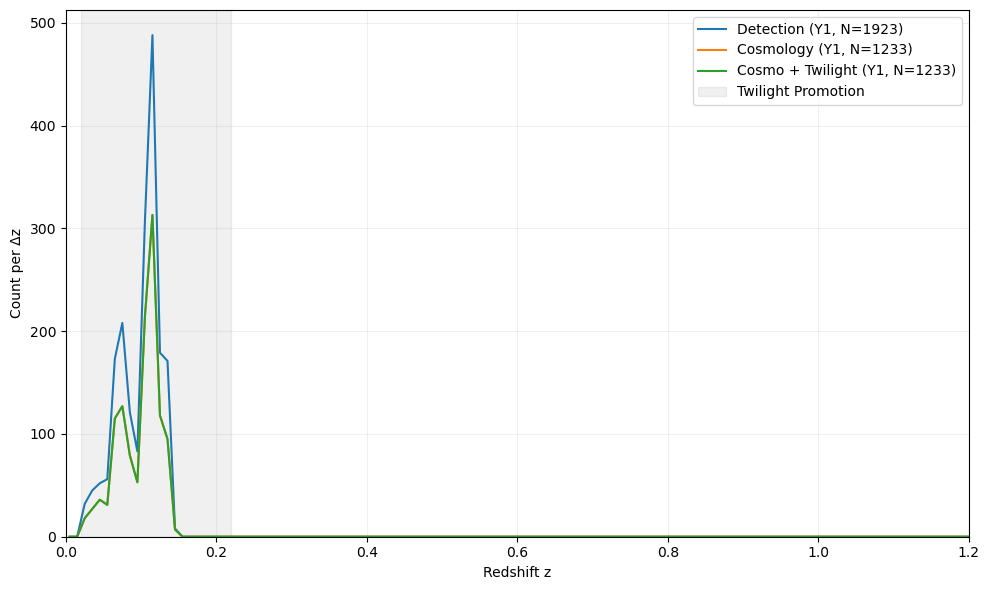

Twilight redshift summaries:
  z∈[0.02,0.06): {'N_det': 185, 'N_cos': 112, 'N_cos_tw': 112}
  z∈[0.02,0.10): {'N_det': 770, 'N_cos': 486, 'N_cos_tw': 486}
  z∈[0.02,0.14): {'N_det': 1915, 'N_cos': 1226, 'N_cos_tw': 1226}
  z∈[0.06,0.10): {'N_det': 585, 'N_cos': 374, 'N_cos_tw': 374}
  z∈[0.10,0.14): {'N_det': 1145, 'N_cos': 740, 'N_cos_tw': 740}


In [7]:
# Plot N(z) for Twilight-only inputs (after QC and Twilight Year-1)
z_edges_tw = np.arange(0.0, Z_MAX + DZ + 1e-12, DZ)
z_mid_tw = 0.5 * (z_edges_tw[:-1] + z_edges_tw[1:])
N_det_tw = nz_hist(tw_head_y1['z'].to_numpy(float), z_edges_tw)
N_tw = nz_hist(tw_fit_qc_y1['z'].to_numpy(float), z_edges_tw)
show_fig_y1_nz(
    z_mid_tw, N_det_tw, N_tw, N_cos_tw=N_tw,
    DZ=DZ, Z_TW_MIN=Z_TW_MIN, Z_TW_MAX=Z_TW_MAX, Z_MAX=Z_MAX,
)
print("Twilight redshift summaries:")
for rng in [(0.02,0.06),(0.02,0.10),(0.02,0.14),(0.06,0.10),(0.10,0.14)]:
    print(f"  z∈[{rng[0]:.2f},{rng[1]:.2f}):", summarize_y1_counts_in_range(z_mid_tw, N_det_tw, N_tw, z_min=rng[0], z_max=rng[1], dz=DZ))


## Bin WFD and Twilight; Combine bins

In [8]:
# Combined catalog already produced via write_binned_catalogs_v2
print(f"Combined WFD+Twilight bins: {len(df_tw_combined)}")
combined_csv = DERIVED / 'y1_cat_bin_tw_Y1_with_TWv4.csv'
df_tw_combined.to_csv(combined_csv, index=False)
print(f"Wrote combined bins → {combined_csv}")


Combined WFD+Twilight bins: 120
Wrote combined bins → /Users/tz/Documents/GitHub/Lsst-Twilight-SNe/Motivation/derived/y1_cat_bin_tw_Y1_with_TWv4.csv


## Forecast: WFD vs WFD+Twilight (combined)

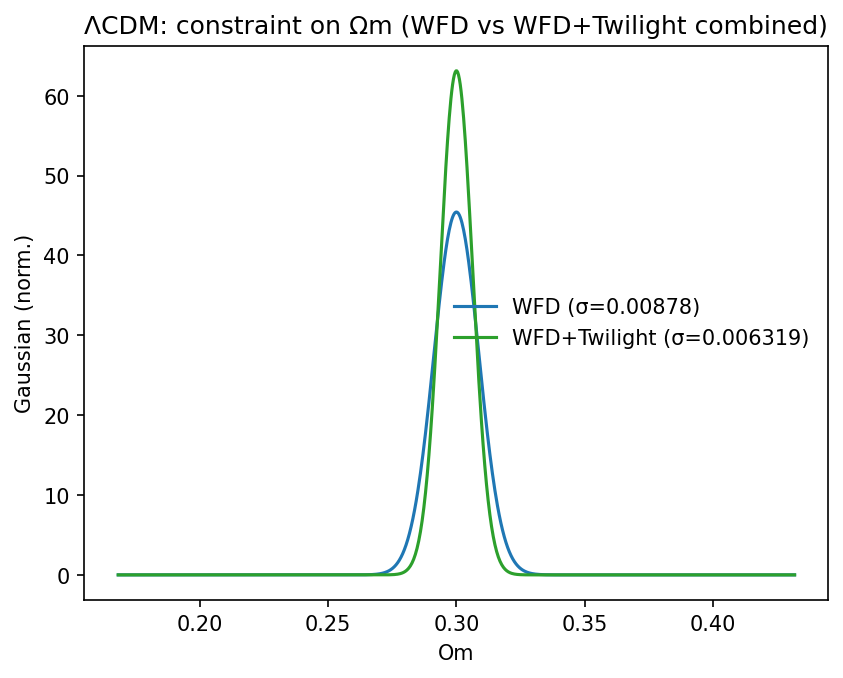

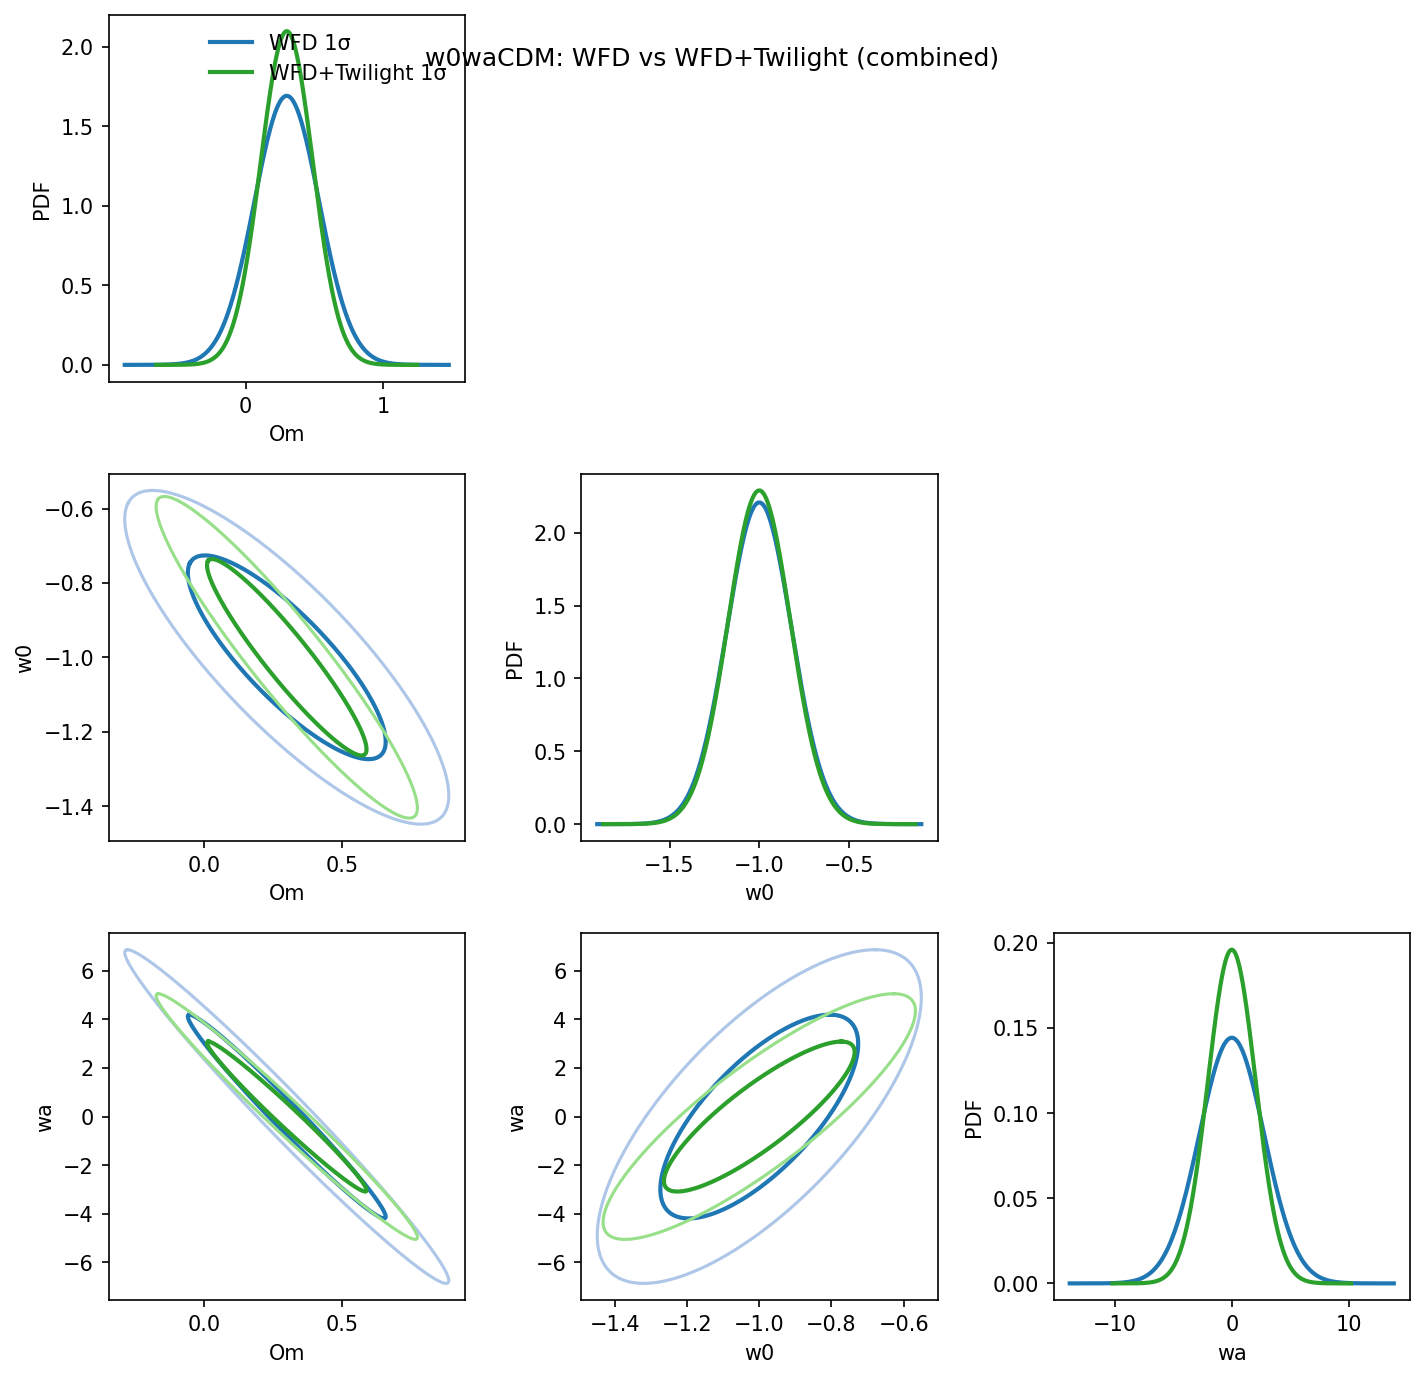

1σ parameter uncertainties (WFD → WFD+Twilight combined):
   Om: WFD=0.00878  WFD+Twilight=0.006319  x1.39


In [9]:
# ΛCDM (Om) and w0wa forecasts
res_lcdm = run_binned_forecast(df_wfd_bin, df_tw_combined, model='lcdm')
res_w0wa = run_binned_forecast(df_wfd_bin, df_tw_combined, model='w0wa')

# Plots in the same style as earlier notebooks
plot_lcdm_1d(res_lcdm, param='Om', title='ΛCDM: constraint on Ωm (WFD vs WFD+Twilight combined)')
plot_corner(res_w0wa, params=('Om','w0','wa'), title='w0waCDM: WFD vs WFD+Twilight (combined)')

# Quick textual summary of improvements
labs = res_lcdm['WFD']['labels']
print('1σ parameter uncertainties (WFD → WFD+Twilight combined):')
for i, p in enumerate(labs):
    s_wfd = float(np.sqrt(res_lcdm['WFD']['cov'][i, i]))
    s_tw  = float(np.sqrt(res_lcdm['WFD+Twilight']['cov'][i, i]))
    print(f'  {p:>3s}: WFD={s_wfd:.4g}  WFD+Twilight={s_tw:.4g}  x{(s_wfd/max(s_tw,1e-12)):.2f}')


## Per-bin differences: WFD vs WFD+Twilight (combined)

In [10]:
# Build a stable integer bin key to avoid float merge duplicates
def _prep(df, n_key, s_key):
    if df is None or df.empty:
        return pd.DataFrame(columns=['z_key', n_key, s_key])
    tmp = df.rename(columns={'N': n_key, 'sigma_mu': s_key}).copy()
    # Robust integer key for the redshift bin; avoid bankers' rounding issues
    tmp['z_key'] = np.floor(tmp['z'] / DZ + 0.5).astype(int)
    # Ensure uniqueness per bin before merging to avoid Cartesian blow-up
    tmp = tmp.groupby('z_key', as_index=False).agg({n_key: 'first', s_key: 'first'})
    return tmp[['z_key', n_key, s_key]]

comp = (_prep(df_wfd_bin, 'N [WFD]', 'sigma_mu [WFD]')
        .merge(_prep(df_tw_only, 'N [Twilight]', 'sigma_mu [Twilight]'), on='z_key', how='outer')
        .merge(_prep(df_tw_combined, 'N [WFD+Twilight]', 'sigma_mu [WFD+Twilight]'), on='z_key', how='outer'))
# Add representative bin-center z from the integer key
comp['z'] = comp['z_key'] * DZ + 0.5 * DZ
# De-duplicate merged rows (defensive) and fill absent counts with 0
comp = comp.drop_duplicates(subset='z_key', keep='first').copy()
for c in ['N [WFD]', 'N [Twilight]', 'N [WFD+Twilight]']:
    if c in comp:
        comp[c] = comp[c].fillna(0).astype(float)
comp['ΔN [Tw-WFD]'] = comp['N [Twilight]'] - comp['N [WFD]']
comp['ΔN [Comb-WFD]'] = comp['N [WFD+Twilight]'] - comp['N [WFD]']
comp['Δsigma_mu [Tw-WFD]'] = comp['sigma_mu [Twilight]'] - comp['sigma_mu [WFD]']
comp['Δsigma_mu [Comb-WFD]'] = comp['sigma_mu [WFD+Twilight]'] - comp['sigma_mu [WFD]']
has_diff = ((comp['ΔN [Tw-WFD]'] != 0) | (comp['ΔN [Comb-WFD]'] != 0) |
            (np.abs(comp['Δsigma_mu [Tw-WFD]']) > 1e-12) | (np.abs(comp['Δsigma_mu [Comb-WFD]']) > 1e-12))
print('Per-bin differences: WFD vs Twilight vs WFD+Twilight (combined) — first 12 rows with changes')
cols = ['z',
        'N [WFD]','sigma_mu [WFD]',
        'N [Twilight]','sigma_mu [Twilight]',
        'N [WFD+Twilight]','sigma_mu [WFD+Twilight]',
        'ΔN [Tw-WFD]','ΔN [Comb-WFD]',
        'Δsigma_mu [Tw-WFD]','Δsigma_mu [Comb-WFD]']
print(comp.loc[has_diff, cols].sort_values('z').head(20).to_string(index=False))


Per-bin differences: WFD vs Twilight vs WFD+Twilight (combined) — first 12 rows with changes
    z  N [WFD]  sigma_mu [WFD]  N [Twilight]  sigma_mu [Twilight]  N [WFD+Twilight]  sigma_mu [WFD+Twilight]  ΔN [Tw-WFD]  ΔN [Comb-WFD]  Δsigma_mu [Tw-WFD]  Δsigma_mu [Comb-WFD]
0.005      0.0        0.299559           0.0             0.167694               0.0                 0.299559          0.0            0.0           -0.131865              0.000000
0.015      1.0        0.299559           0.0             0.167694               1.0                 0.299559         -1.0            0.0           -0.131865              0.000000
0.025      2.0        0.172033          18.0             0.167694              32.0                 0.157565         16.0           30.0           -0.004339             -0.014468
0.035      2.0        0.141352          27.0             0.144348              45.0                 0.140747         25.0           43.0            0.002996             -0.000605
0.045      5